# Analyse des données fournies par Assur'Aimant

Dans le but de réaliser une régression linéaire pour prédire "rapidement" une valeur de la colonne "charges",
analysons l'influence des valeurs de chaque autre colonne sur celle ci.

In [48]:
import pandas as pd
df = pd.read_csv("dataset.csv")
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [49]:
def get_region_code(region :str) -> int :
    match region : 
        case "northeast" : return 1 
        case "northwest" : return 2
        case "southwest" : return 3
        case "southeast" : return 4
        case _ : raise Exception("It should not happen")

dataframe_exploitable = df.copy()
dataframe_exploitable["sex"] = df["sex"].apply( lambda x : 1 if x == "male" else 0)
dataframe_exploitable["smoker"] = df["smoker"].apply( lambda x : 1 if x == "yes" else 0)
dataframe_exploitable["region"] = df["region"].apply( lambda x : get_region_code(x))
dfe = dataframe_exploitable
dfe.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,3,16884.9240
1,18,1,33.77,1,0,4,1725.5523


# 1. Analyse univariée
D'abord chaque colonne séparément


## 1.1. Influence de l'age de l' assuré

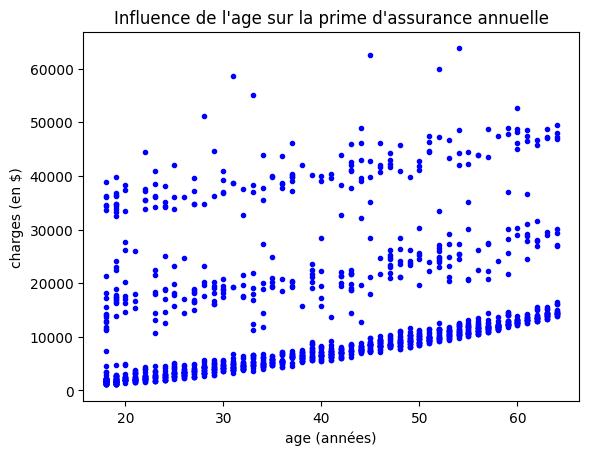

In [50]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array(dfe, dtype=float)

#Colonne age ( index = 0 )
plt.xlabel("age (années)") # index = 0
plt.ylabel("charges (en $)") # index = 6
plt.plot(data[:,0], data[:,6], 'b.')
plt.title("Influence de l'age sur la prime d'assurance annuelle")
plt.show()

La prime d'assurance ( valeur de la colonne "charges") croit globalement avec l'age.

La relation ${charges} = f({age})$ semble linéaire : $${charges} = {A} \times {age} + {B} $$
ou peut être légèrement quadratique : $${charges} = {A} \times {age^2}  + {B} \times {age} + {C} $$


On peut donc choisir la colonne age comme un bon indicateur de base de la régression linéaire.

##  1.2. Influence du sexe de l'assuré

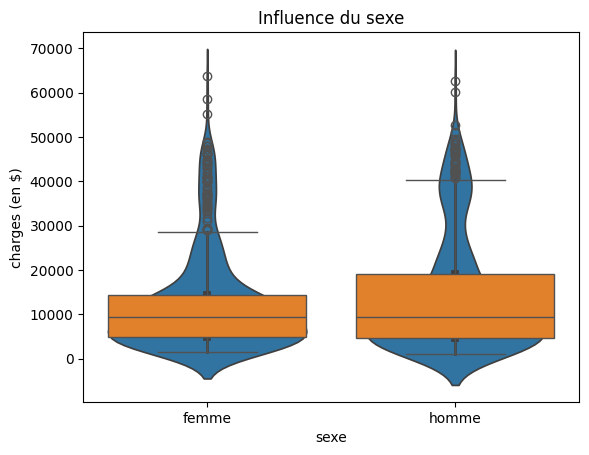

In [51]:
import seaborn as sns

df_renamed = pd.DataFrame(df)
df_renamed["sex"] = df_renamed["sex"].apply(lambda x : "homme" if x=="male" else "femme")

#Colonne sex ( index = 1 )
plt.xlabel("sexe") # index = 1
plt.ylabel("charges (en $)") # index = 6

sns.violinplot(x=df_renamed['sex'], y=df_renamed['charges']) 
sns.boxplot(x=df_renamed['sex'], y=df_renamed['charges']) 
plt.xlabel("sexe") # index = 1
plt.ylabel("charges (en $)") # index = 6
plt.title('Influence du sexe')
plt.show()

Peu d'influence sur les charges pour le sexe.

##  1.3. Influence de l'indice de masse corporelle

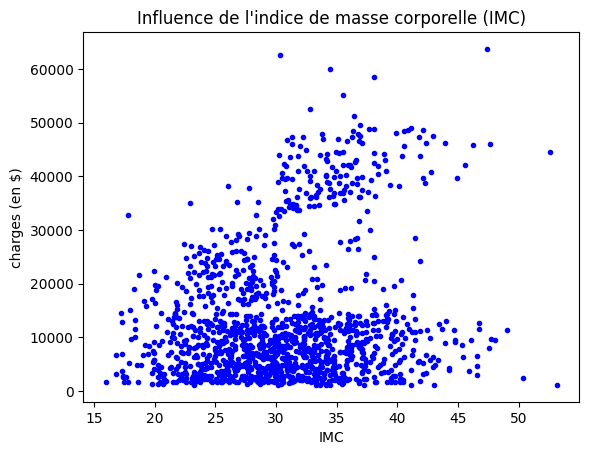

In [52]:
#Colonne bmi ( index = 2 )
plt.xlabel("IMC") # index = 2
plt.ylabel("charges (en $)") # index = 6

#sns.boxplot(x=df['bmi'], y=df['charges']) 
plt.plot(data[:,2], data[:,6], 'b.')
plt.title("Influence de l'indice de masse corporelle (IMC)")
plt.show()

Pas de relation évidente mais les données ne sont pas équilibrées : il existe une relation non triviale.

##  1.4. Influence du nombre d'enfants à charge

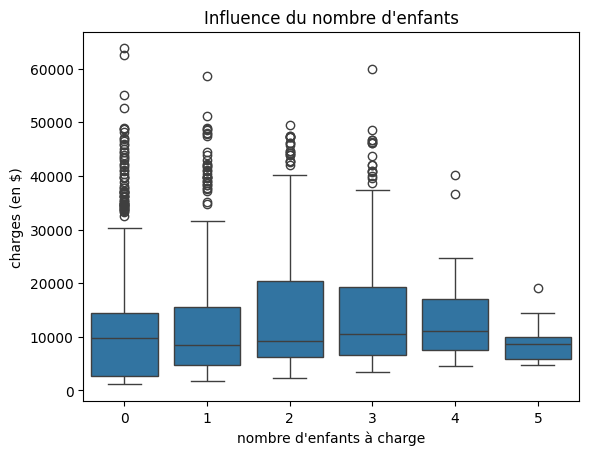

In [53]:
#Colonne children (index = 3)
plt.xlabel("nombre d'enfants à charge") # index = 3
plt.ylabel("charges (en $)") # index = 6
sns.boxplot(x=df['children'], y=df['charges'])
plt.title("Influence du nombre d'enfants")
plt.show()

Pas de relation évidente.

##  1.5. Influence du fait d'être fumeur

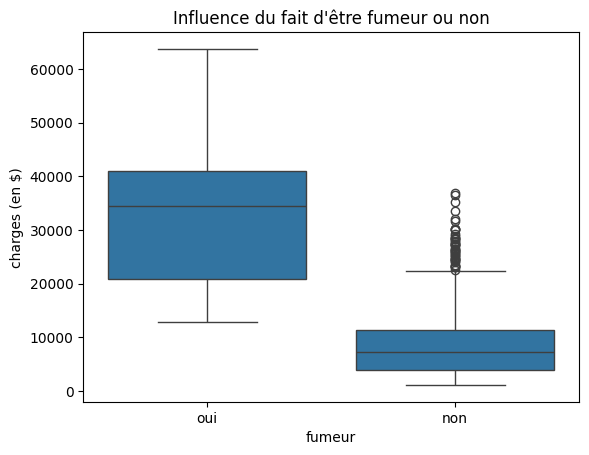

In [ ]:
df_renamed["smoker"] = df_renamed["smoker"].apply( lambda x : "oui" if x=="yes" else "non")

#Colonne smoker (index = 4 )
plt.xlabel("fumeur") 
plt.ylabel("charges (en $)")
sns.boxplot(x=df_renamed['smoker'], y=df_renamed['charges'])
plt.title("Influence du fait d'être fumeur ou non")
plt.show()


Enorme influence, très significative.

Il y a clairement un lien : l'assuré paye beaucoup plus cher sa prime d'assurance quand il est fumeur.

## 1.6. Influence de la region

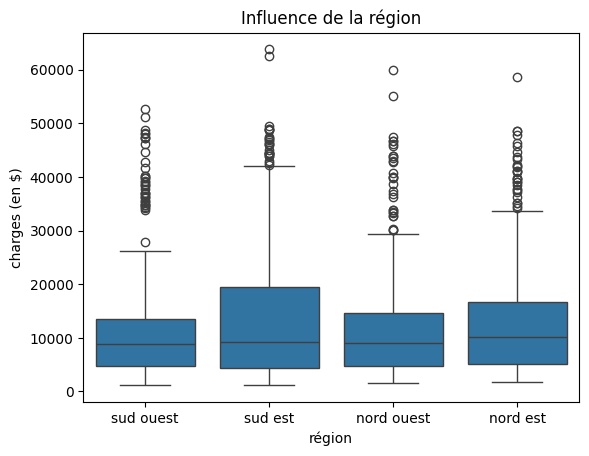

In [ ]:
def numerize_region(region :str) -> int :
    match region : 
        case "southwest" : return 1
        case "northwest" : return 2
        case "northeast" : return 3
        case "southeast" : return 4
        case _ : raise Exception("It should not happen")

def translate_region(region :str) -> str :
    int_region = int(region)
    match int_region : 
        case 1 : return "sud ouest" 
        case 2 : return "nord ouest" 
        case 3 : return "nord est" 
        case 4 : return "sud est" 
        case _ : raise Exception("It should not happen")

df_renamed["region"] = df_renamed["region"].apply( lambda x : numerize_region(x))
df_renamed["region"] = df_renamed["region"].apply( lambda x : translate_region(x))

#Colonne region (index = 5 )
plt.xlabel("région") 
plt.ylabel("charges (en $)")
sns.boxplot(x=df_renamed['region'], y=df_renamed['charges'])
plt.title("Influence de la région")
plt.show()

la médiane est proche, l'écart interquartile $Q_3 - Q_1$ est plus grand dans l'est.

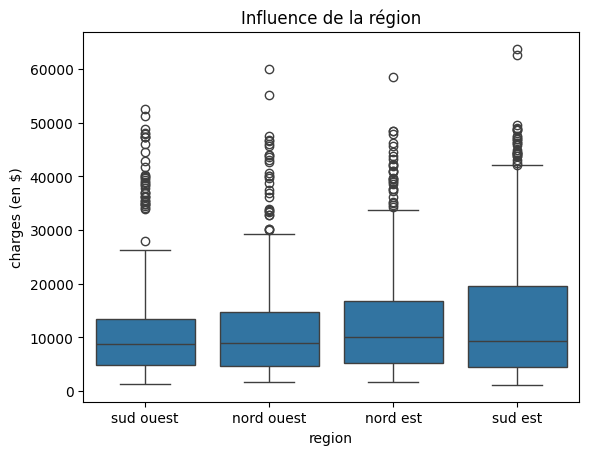

In [ ]:
df_reordered = pd.DataFrame(df)
df_reordered["region"] = df_reordered["region"].apply( lambda x : numerize_region(x))
df_reordered.sort_values( 'region', ascending=True, inplace=True)
df_reordered["region"] = df_reordered["region"].apply( lambda x : translate_region(x))

sns.boxplot(x=df_reordered['region'], y=df_reordered['charges'])
plt.xlabel("region") 
plt.ylabel("charges (en $)")
plt.title("Influence de la région")
plt.show()

Ce n'est pas un lien si évident que ça.

Il semble bien qu'il y ait quelque chose qui se passe dans l'est, et plus exactement dans le sud est des états-unis, Les primes d'assurances pouvant y être plus élevées.

# 2. Analyse bivariée
Une première approche peut être d'afficher la matrice de corrélation (linéaire) des variables
    

In [57]:
correlation_matrix = dfe.corr()
correlation_matrix_without_diagonal = correlation_matrix.where(np.identity(correlation_matrix.shape[0]) != 1,0)

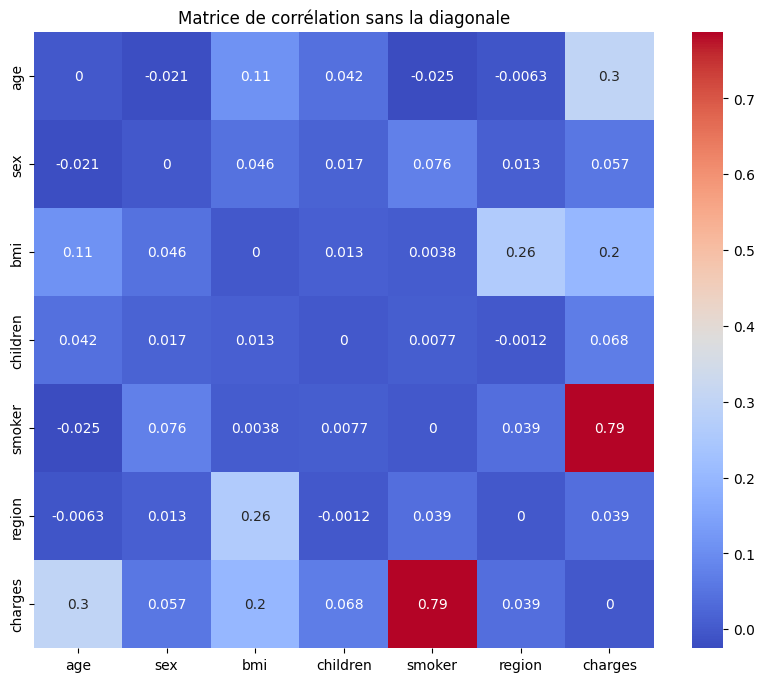

In [58]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_without_diagonal, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation sans la diagonale")
plt.show()

## 2.1. Relations linéaires avec la prime d'assurance
L'influence de chaque variable sur les charges apparait dans la dernière colonne et la dernière ligne.
- La prime d'assurance est fortement corrélée avec le fait d'être fumeur ( 0.79 )
- L'age est le second poste ( 0.30  )
- L'indice de masse corporelle (IMC, bmi) intervient en troisième position ( 0.20 )
- Le nombre d'enfants intervient de manière plus faible en quatrième ( 0.07 )
- En cinquième le sexe ( 0.06 )
- En dernier la région ( 0.04 )

On peut dors et déjà supposer que si le coefficient de corrélation est inférieur à 0.10 en valeur absolue ( +/- 10% ), la valeur n'aura que peu d'influence sur les charges.

Sont donc dans le peloton de tête pour leur contribution à la régression linéaire: smoker , age et bmi.

On pourrait imaginer se passer des colonnes: children, sex et region.

## 2.2. Relations des variables entre elles

### 2.2.1 Relations croisées avec le fait dêtre fumeur
cinq croisements possibles : age, bmi children, sexe, region
#### 2.2.1.1 Relation smoker - age


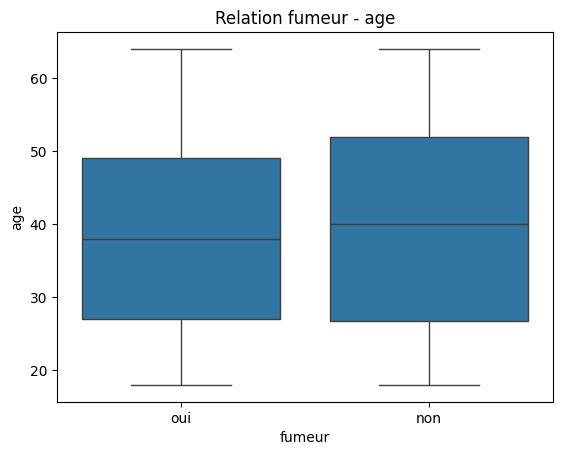

In [66]:
df_renamed = pd.DataFrame(df)
df_renamed["smoker"] = df_renamed["smoker"].apply( lambda x : "oui" if x=="yes" else "non")

sns.boxplot(x=df_renamed['smoker'], y=df_renamed['age'])
plt.xlabel("fumeur") 
plt.ylabel("age")
plt.title("Relation fumeur - age")
plt.show()

La médiane des non fumeurs est plus élevée. Pas de surprise, les non fumeurs vivent plus longtemps.

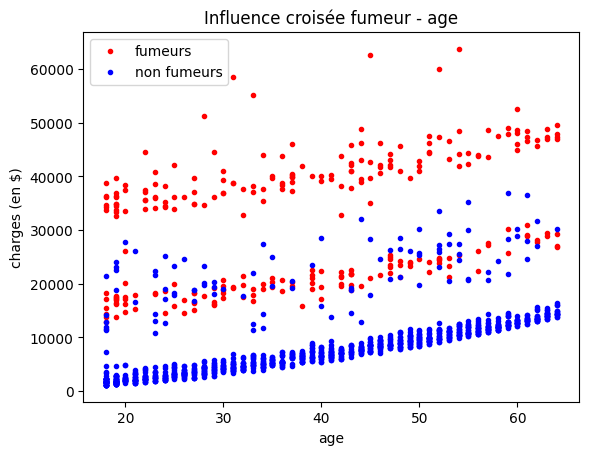

In [60]:
# Lien avec les charges :
data_S = np.array(df[df["smoker"]=="yes"]) 
data_N = np.array(df[df["smoker"]=="no"])

plt.xlabel("age") 
plt.ylabel("charges (en $)")
plt.plot(data_S[:, 0], data_S[:, 6], "r.", label="fumeurs") 
plt.plot(data_N[:, 0], data_N[:,6], "b.", label="non fumeurs") 
plt.title("Influence croisée fumeur - age")
plt.legend()
plt.show()

On distingue 3 parties distinctes sur lesquelles les individus sont placés.

Chaque partie peut se modéliser comme une droite d'équation ${charges} = f({age}) = {A} \times {age} + {B} $

Les trois droites semblent parallèles.

- Une droite basse (qui paye peu de charges) est constituée exclusivement de non fumeurs: 
$${charges_0} = {A} \times {age} + {B_0} $$ 
- Une droite médiane constituée de fumeurs et de non fumeurs : 
$${charges_1} = {A} \times {age} + {B_1} $$ 
- Une droite haute constituée exclusivement de fumeurs :  
$${charges_2} = {A} \times {age} + {B_2} $$  

Les deux variables smoker et age semblent assez bien modéliser les charges de manière linéaire.
il existe cependant une variable (probablement avec un seuil) non étudiée jusque là qui influence la valeur de la prime d'assurance charges

#### 2.2.1.2 Relation smoker - bmi


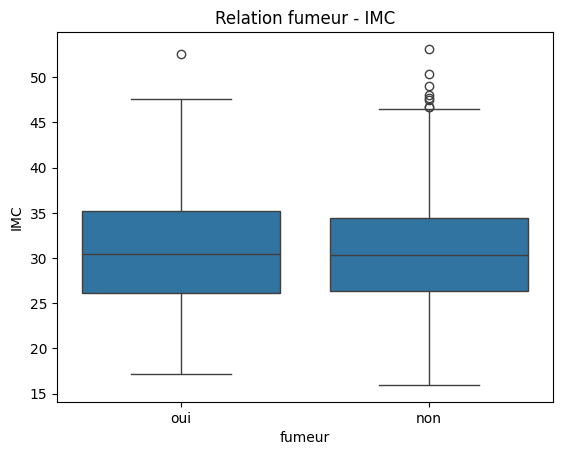

In [68]:
#Colonne smoker
sns.boxplot(x=df_renamed['smoker'], y=df_renamed['bmi'])
plt.xlabel("fumeur") 
plt.ylabel("IMC")
plt.title("Relation fumeur - IMC")
plt.show()

médiane et intervale interquartile similaires : Pas de corrélation entre smoker et bmi.

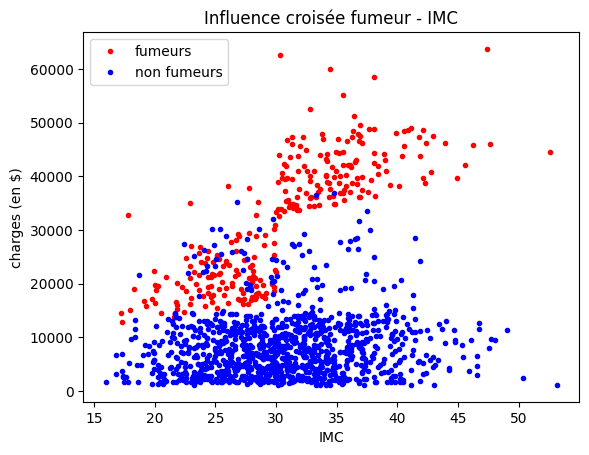

In [62]:
# Lien avec les charges :
data_S = np.array(df[df["smoker"]=="yes"]) 
data_N = np.array(df[df["smoker"]=="no"])

plt.xlabel("IMC") # index = 2
plt.ylabel("charges (en $)") # index = 6
plt.plot(data_S[:, 2], data_S[:, 6], "r.", label="fumeurs") # charges = f ( bmi )
plt.plot(data_N[:, 2], data_N[:,6], "b.",  label="non fumeurs") # charges = f ( bmi )
plt.title("Influence croisée fumeur - IMC")
plt.legend()
plt.show()


On distingue une différence nette entre les fumeurs (qui payent plus cher)  et les non fumeurs (qui payent moins cher).

Un seuil apparait pour les fumeurs à la valeur IMC = 30.
les fumeurs dont l'IMC est supérieur à 30 payent significativement plus cher leur prime d'assurance.

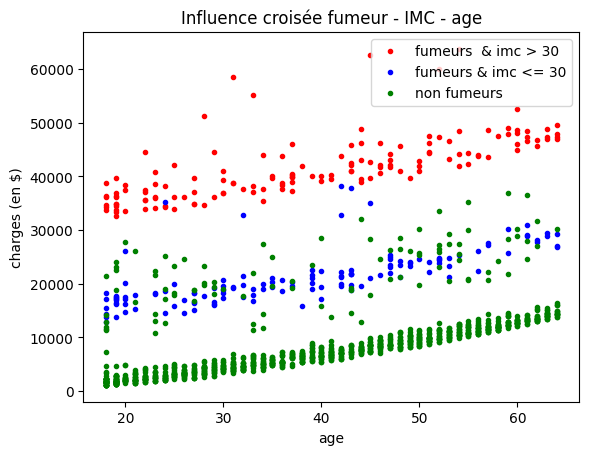

In [63]:
# Lien avec les charges :
data_S_fat = np.array( df[(df["smoker"]=="yes") & (df["bmi"] > 30.0) ] ) 
data_S_thin = np.array(df[(df["smoker"]=="yes") & (df["bmi"] <= 30.0) ]) 
data_N = np.array( df[df["smoker"]=="no" ] ) 

plt.xlabel("age") 
plt.ylabel("charges (en $)")
plt.plot(data_S_fat[:, 0], data_S_fat[:, 6], "r.", label="fumeurs  & imc > 30") 
plt.plot(data_S_thin[:, 0], data_S_thin[:, 6], "b.", label="fumeurs & imc <= 30") 
plt.plot(data_N[:, 0], data_N[:, 6], "g.", label="non fumeurs") 

plt.title("Influence croisée fumeur - IMC - age")
plt.legend()
plt.show()

On reconnait les trois parties citées dans le paragraphe sur les relations fumeur - age
- non fumeurs en bas
- fumeurs avec imc < 30 dans la zone médiane
- fumeurs avec imc > 30 en haut




#### 2.2.1.3 Relation smoker - children

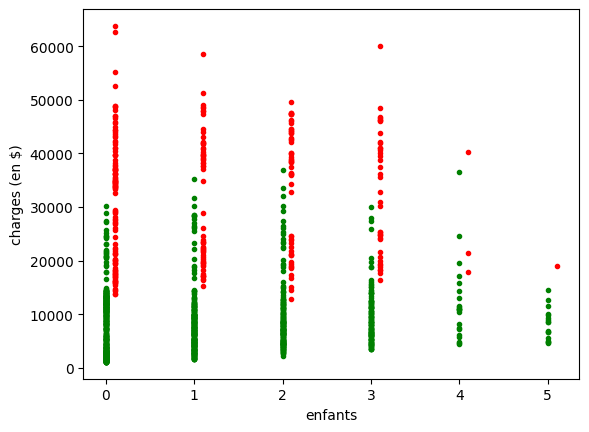

In [73]:
# Lien avec les charges :
plt.xlabel("enfants") # index = 3  
plt.ylabel("charges (en $)")

df_smoker = pd.DataFrame(df[df["smoker"]=="yes"])
df_smoker["children"] = df_smoker["children"].apply(lambda x : x+0.1) 
data_S = np.array(df_smoker) 
data_N = np.array(df[(df["smoker"]=="no") ] ) 

plt.plot(data_S[:, 3], data_S[:, 6], 'r.', label ="fumeurs") 
plt.plot(data_N[:, 3], data_N[:, 6], 'g.', label ="non fumeurs") 

plt.show()

A nombre d'enfant égal, les fumeurs payent plus cher


#### 2.2.1.4 Relation smoker - sexe


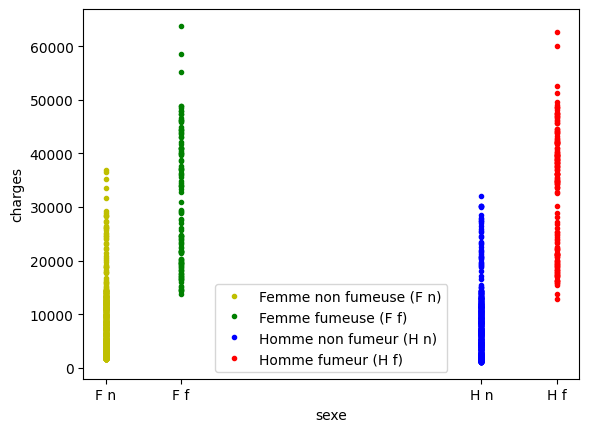

In [87]:
# Lien avec les charges :
plt.xlabel("sexe") # index = 1
plt.ylabel("charges")

#dfe contient déjà des valeurs numériques
df_no_smoke_woman = pd.DataFrame(dfe[(dfe["smoker"]==0) & (dfe["sex"]==0) ])
df_smoke_woman = pd.DataFrame(dfe[(dfe["smoker"]==1) & (dfe["sex"]==0) ])
df_no_smoke_man = pd.DataFrame(dfe[(dfe["smoker"]==0) & (dfe["sex"]==1) ])
df_smoke_man = pd.DataFrame(dfe[(dfe["smoker"]==1) & (dfe["sex"]==1) ])

df_no_smoke_woman["sex"] = df_no_smoke_woman["sex"].apply(lambda x : -3)
df_smoke_woman["sex"] = df_smoke_woman["sex"].apply(lambda x : -2)
df_no_smoke_man["sex"] = df_no_smoke_man["sex"].apply(lambda x : 2)
df_smoke_man["sex"] = df_smoke_man["sex"].apply(lambda x : 3)


data_WN = np.array(df_no_smoke_woman)
data_WS = np.array(df_smoke_woman)
data_MN = np.array(df_no_smoke_man)
data_MS = np.array(df_smoke_man)

plt.plot(data_WN[:, 1], data_WN[:, 6], 'y.', label ="Femme non fumeuse (F n)")
plt.plot(data_WS[:, 1], data_WS[:, 6], 'g.', label ="Femme fumeuse (F f)")
plt.plot(data_MN[:, 1], data_MN[:, 6], 'b.', label ="Homme non fumeur (H n)")
plt.plot(data_MS[:, 1], data_MS[:, 6], 'r.', label ="Homme fumeur (H f)")

plt.xticks([-3, -2, 2, 3], ['F n', 'F f', 'H n', 'H f'])

plt.legend()

plt.show()

Qu'ils soient hommes ou femmes les fumeurs payent plus cher.

#### 2.2.1.5 Relation smoker - region

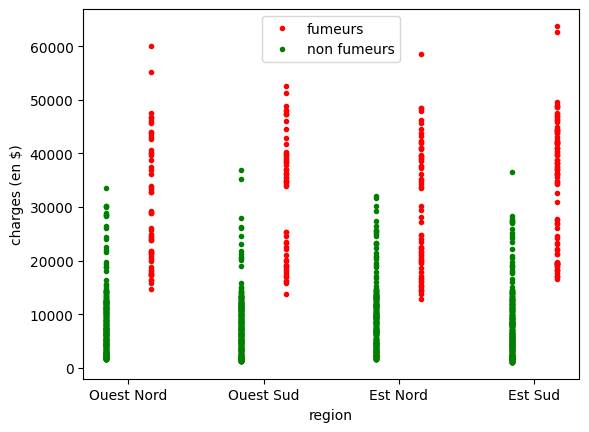

In [90]:
def numerize_region(region :str) -> int :
    match region : 
        case "northwest" : return -9
        case "southwest" : return -3
        case "northeast" : return 3
        case "southeast" : return 9
        case _ : raise Exception("It should not happen")

# Lien avec les charges :
plt.xlabel("region") # index = 5
plt.ylabel("charges (en $)")

df_regions = pd.DataFrame(df)
df_regions["region"] = df_regions["region"].apply(lambda x : numerize_region(x))

df_smoker = pd.DataFrame(df_regions[df_regions["smoker"]=="yes"])
df_smoker["region"] = df_smoker["region"].apply(lambda x : x + 1)
data_S = np.array(df_smoker)

df_no_smoker = pd.DataFrame(df_regions[df_regions["smoker"]=="no"])
df_no_smoker["region"] = df_no_smoker["region"].apply(lambda x : x -1)
data_N = np.array(df_no_smoker)

plt.plot(data_S[:, 5], data_S[:, 6], 'r.', label ="fumeurs") 
plt.plot(data_N[:, 5], data_N[:, 6], 'g.', label ="non fumeurs") 

plt.xticks([ -9, -3, 3, 9], ['Ouest Nord', 'Ouest Sud', 'Est Nord', 'Est Sud'])

plt.legend()

plt.show()

Pas de relation significative, répartition similaire dans toutes les régions

### 2.2.2 Relations croisées avec l'age
quatre croisements restant possibles : bmi, children, sexe, region
#### 2.2.2.1 Relation age - bmi


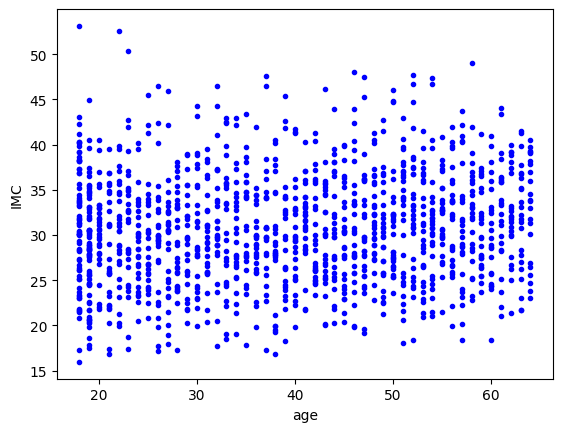

In [132]:
data = np.array(dfe)

plt.xlabel("age")
plt.ylabel("IMC")
plt.plot(data[:, 0], data[:,2], 'b.')
plt.show()

L'indice de masse corporelle semble croitre "un petit peu" avec l'age.
Pour aller plus loin on pourrait afficher une valeur de tendance centrale par tranche de 10 ans par exemple.

Le coefficient de corrélation age - bmi est à 0.11 ce qui nous place très légèrement au dessus de la limite de signifiance choisie (arbitrairement) à 0.10 (10 %).

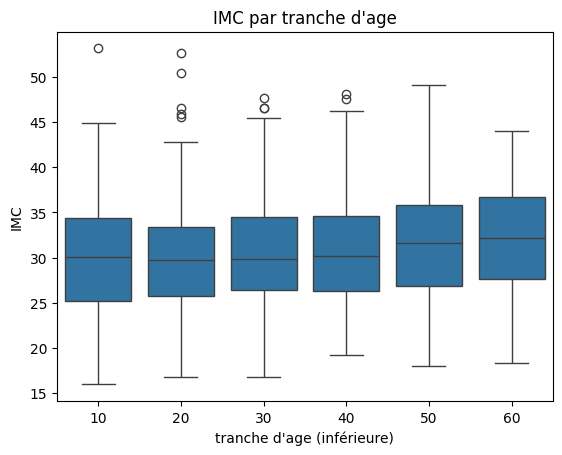

In [133]:
df_age = pd.DataFrame(df)
df_age["age"] = df_age["age"].apply( lambda x : (x//10)*10 )
plt.xlabel("tranche d'age (inférieure)")
plt.ylabel("IMC")
plt.title("IMC par tranche d'age")
sns.boxplot(x=df_age['age'], y=df_age['bmi'])
plt.show()

Oui, l'IMC croit un petit peu avec l'age. Il y aurait de quoi faire une régression linéaire. 

#### 2.2.2.2 Relation age - children


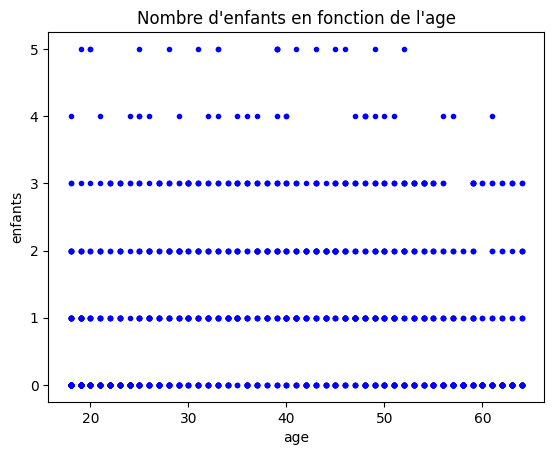

In [138]:
data = np.array(dfe, dtype = float)

plt.xlabel("age")
plt.ylabel("enfants") # index = 3
plt.title("Nombre d'enfants en fonction de l'age")
plt.plot(data[:,0], data[:,3], 'b.')
plt.show()

Voilà quelque chose d'étonnant : certaines personnes assurées ont 5 enfants à charge et moins de 20 ans.

Cette répartition est surprenante. "très réguliere"


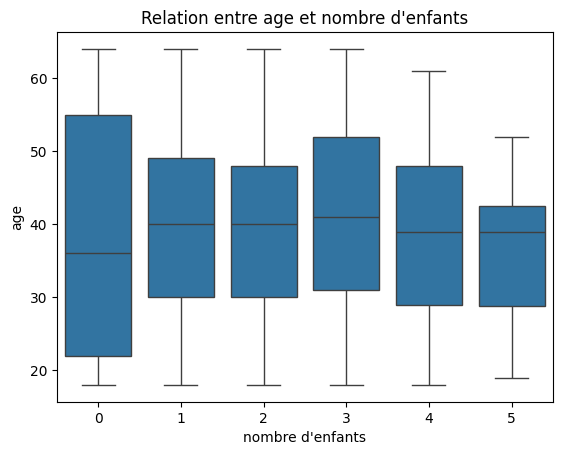

In [188]:
plt.xlabel("nombre d'enfants")
plt.ylabel("age")
plt.title("Relation entre age et nombre d'enfants")
sns.boxplot(df, x="children", y="age")
plt.show()

La première boite à moustache, plus étendue peut s'expliquer par toutes les autres : la période pendant laquelle un adulte a un enfant à charge est restreinte à 20 ans (en gros).

Avant la ménopause des femmes (40 ans) le nombre d'enfants croit. Puis, après 40 ans, le nombre d'enfants des femmes se stabilise, puis décroit.

Médiane à 40 ans, c'est à peu près logique. 
Ecart interquartile de 50 - 30 = 20 ans, ça tient la route.

Quant - a ceux qui n'ont pas d'enfant : il en existe à tout age, donc l'écart interquartile est élevé.

Pourquoi une médiane avant 40 ans ? C'est de cette population (à 0 enfants) dont seraient issus ceux qui ont 1 enfant (causal : les premiers sont là avant les seconds) . Ceux qui ont 1 enfant seraient donc plus vieux que quand il n'en avaient pas. - mais cette relation ne se vérifie pas pour deux enfants. Ceux ayant 2 enfants ne semblent pas significativement plus vieux que ceux n'en ayant qu'un.



Pas de relation linéaire entre age et nombre d'enfants à charge. 

#### 2.2.2.3 Relation age - sexe


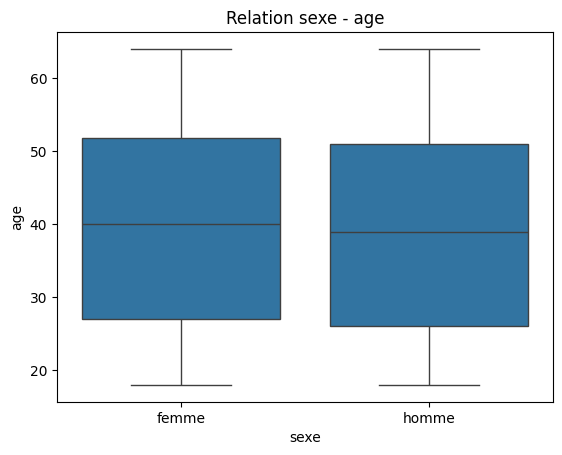

In [142]:
df_renamed = pd.DataFrame(df)
df_renamed["sex"] = df_renamed["sex"].apply( lambda x : "homme" if x=="male" else "femme")

sns.boxplot(x=df_renamed['sex'], y=df_renamed['age'])
#sns.violinplot(x=df_renamed['sex'], y=df_renamed['age'])
plt.xlabel("sexe") 
plt.ylabel("age")
plt.title("Relation sexe - age")
plt.show()

Pas de surprise : les femmes vivent "légèrement" plus longtemps que les hommes.

#### 2.2.2.4 Relation age - region


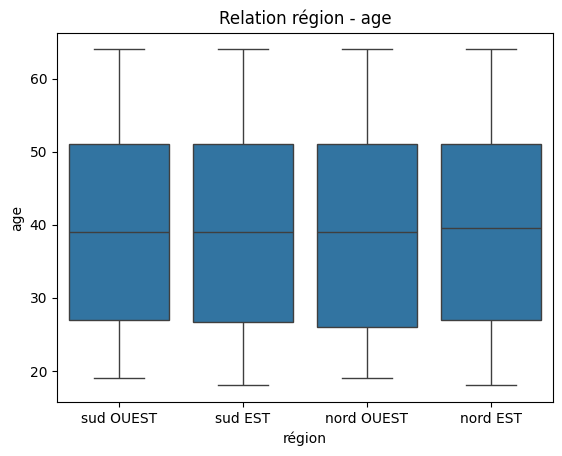

In [179]:
def translate_region(region : str) -> int :
    match region : 
        case "northwest" : return 'nord OUEST'
        case "southwest" : return 'sud OUEST'
        case "northeast" : return 'nord EST'
        case "southeast" : return 'sud EST'
        case _ : raise Exception("It should not happen")

df_reg = pd.DataFrame(df)
df_reg["region"] = df_reg["region"].apply(lambda x : translate_region(x))


plt.xlabel("région")
plt.ylabel("age")
plt.title("Relation région - age")

sns.boxplot(df_reg, x="region", y="age")
#sns.violin(df_reg, x="region", y="age")

plt.show()


Aucune relation "franche" entre l'age et la région.


### 2.2.3 Relations croisées avec l'IMC
trois croisements restant possibles : children, sexe, region
#### 2.2.3.1 Relation bmi - children


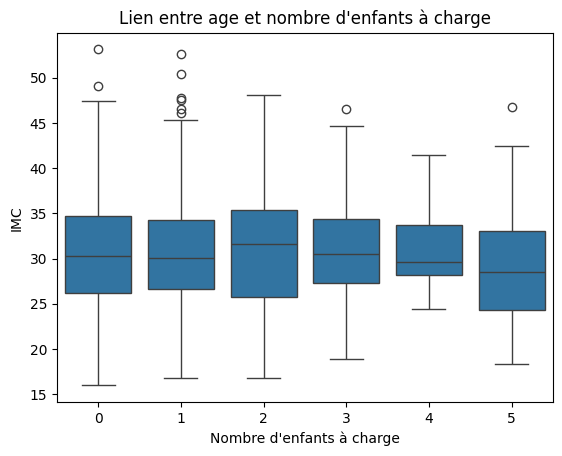

In [181]:
plt.ylabel("IMC")
plt.xlabel("Nombre d'enfants à charge")
plt.title("Lien entre age et nombre d'enfants à charge")

sns.boxplot(df, x="children", y="bmi")
#sns.violin(df_reg, x="region", y="age")

plt.show()

Il est étonnant que l'on soit un peu plus "gros" (IMC médian élevé) quand on a 2 enfants que 0, 1, 3, 4 ou 5.
Peut être que jusqu'à deux enfants on arrive à bien manger mais qu'au delà on a plus assez pour nourrir tout le monde (interprétation 1) ou bien on a tellement de soucis qu'on maigrit d'épuisement (interprétation 2).

Le diagramme en boite à moustache (boxplot) pour 5 enfants se démarque des autres.

In [176]:
print(" ____________ ___________________ ")
print("| nb enfants | individus comptés |")
print("|____________|___________________|")
for n in range(0,6):
    record_count = len(df[df["children"]==n])
    print(f"|     {n}      |        {record_count}", end='')
    nb = len(str(record_count))
    print(" "*(11-nb), end='')
    print("|")
    print("|____________|___________________|")



 ____________ ___________________ 
| nb enfants | individus comptés |
|____________|___________________|
|     0      |        574        |
|____________|___________________|
|     1      |        324        |
|____________|___________________|
|     2      |        240        |
|____________|___________________|
|     3      |        157        |
|____________|___________________|
|     4      |        25         |
|____________|___________________|
|     5      |        18         |
|____________|___________________|


Il y a beaucoup moins d'individus ayant 4 et 5 enfants à charge que ceux en ayant de 0 à 3.

Par rapport aux individus ayant de 0 à 3 enfants, les valeurs calculées pour 4 et 5 enfants, cas qui sont plus rares, donnent lieu à davantage d'aléa sur la médiane et les quartiles affichés dans le boxplot.

Il serait possible de considérer les individus ayant une valeur children à 4 ou 5 comme des valeurs "rares".

Voire "abérantes" si besoin, à cause de la faible précision des indicateurs qu'elles engendrent.

#### 2.2.3.2 Relation bmi - sex


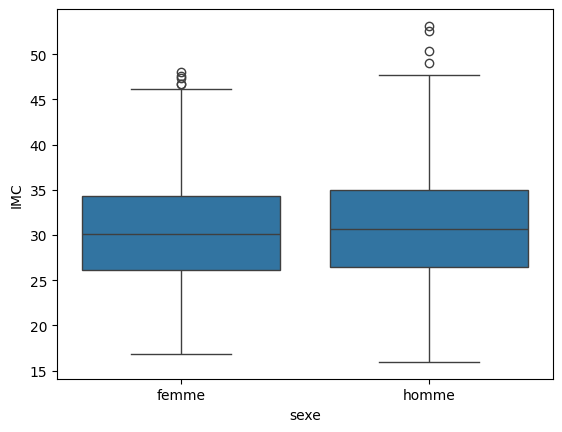

In [178]:
plt.ylabel("IMC")
plt.xlabel("sexe")

sns.boxplot(df_renamed, x="sex", y="bmi")
#sns.violin(df_reg, x="region", y="age")

plt.show()

Les hommes sont "légèrement" plus gros que les femmes

#### 2.2.3.3 Relation bmi  region


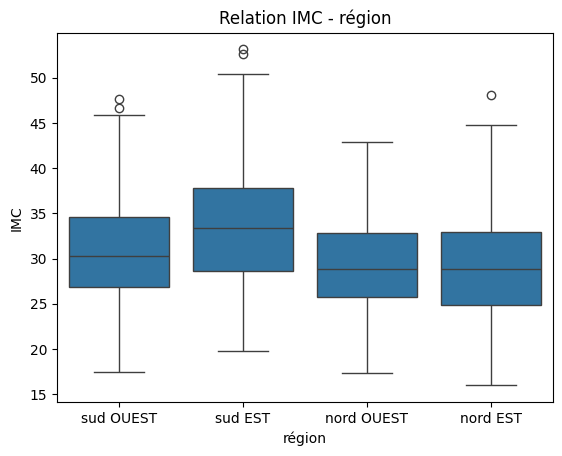

In [183]:
plt.xlabel("région")
plt.ylabel("IMC")
plt.title("Relation IMC - région")

sns.boxplot(df_reg, x="region", y="bmi")

plt.show()

Il semble bien qu'au sud est des états unis ( vers Los Angeles ) il y ait davantage de grosses personnes.


### 2.2.4 Relations croisées avec le nombre d'enfants
deux croisements restant possibles : sexe, region
#### 2.2.4.1 Relation children - sex


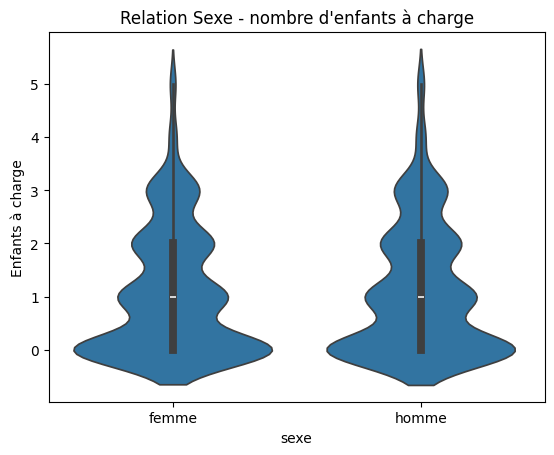

In [ ]:
plt.xlabel("sexe")
plt.ylabel("Enfants à charge")
plt.title("Relation Sexe - nombre d'enfants à charge")

#sns.boxplot(df_renamed, x="sex", y="children")
sns.violinplot(df_renamed, x="sex", y="children")

plt.show()

Egalité des sexes ! une très belle parité ici.

Les valeurs du nombre d'enfants à charge sont discrètes : ça se traduit sur le violinplot par des vagues. Ce phénomène numérique est sans doute bien connu.

ça n'arrive pas avec le boxplot : $Q_1 = 0$ , $mediane = 1$ , $Q_3 = 2$

#### 2.2.4.2 Relation children - region


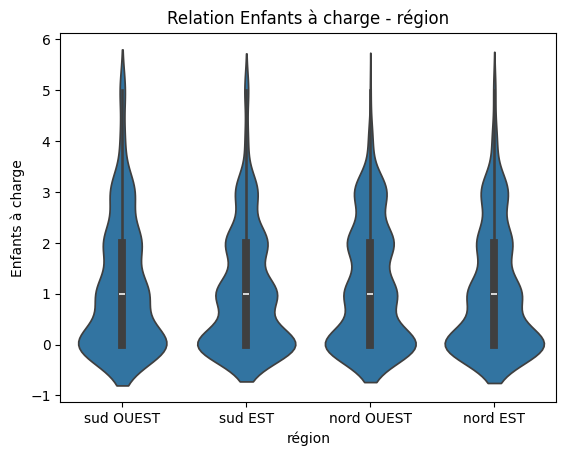

In [203]:
plt.xlabel("région")
plt.ylabel("Enfants à charge")
plt.title("Relation Enfants à charge - région")

sns.violinplot(df_reg, x="region", y="children")

plt.show()

Pas de relation notable.


### 2.2.5 Relations croisées avec le sexe


Un seul croisement n'a pas été traité : region
#### 2.2.5.1 Relation sex - region


In [217]:


print(" ____________ ________ ________")
print("|            |        |        |")
print("|   region   | hommes | femmes |")
print("|____________|________|________|")
for region in ["nord OUEST", "sud OUEST", "nord EST", "sud EST"] : 
    print("|            |        |        |")

    df_region = pd.DataFrame(df_reg[df_reg["region"]==region])
    men_count = len(df_region[df_region["sex"]=="male"])
    women_count = len(df_region[df_region["sex"]!="male"])
    print(f"| {region}{(10 - len(region))*" "} ", end='')
    print(f"| {men_count}{(7 - len(str(men_count)))*" "}", end ='')
    print(f"| {men_count}{(7 - len(str(men_count)))*" "}|")
    print("|____________|________|________|")

 ____________ ________ ________
|            |        |        |
|   region   | hommes | femmes |
|____________|________|________|
|            |        |        |
| nord OUEST | 161    | 161    |
|____________|________|________|
|            |        |        |
| sud OUEST  | 163    | 163    |
|____________|________|________|
|            |        |        |
| nord EST   | 163    | 163    |
|____________|________|________|
|            |        |        |
| sud EST    | 189    | 189    |
|____________|________|________|


La population d'assurés est plus élevée dans le sud est ( Miami, New Orleans ).
Les hommes et femmes sont répartis équitablement.


# 3. Conclusion 

Les variables pertinentes pour la régression linéaire en vue de la prévision de la valeur ${charges} = y$ sont 
- ${smoker} = x_1 = s $
- ${age} = x_2 = a $
- ${bmi} = x_3 = b $

On peut s'attendre à une expression pouvant ressembler à :

$$ {y} = a \times x_2 + b(x_1, x_3)$$

avec $ b(x_1, x_3) $ pouvant prendre 3 ou 4 valeurs distinctes, 

selon que $x_1 == 1$ (fumeur) ou $x_1 == 0$ (non fumeur)

et que $x_3 > 30 $ (IMC > 30) ou $x_3 < 30$ (IMC > 30)